# Model 0.05 - Breeds
 - Some breeds not shared between test and train data
 - Breeds could be categorised (e.g. Terrier), so decided to split breed name into keywords
 - Used only test data breeds for flags (1.7 pct point increase in LB)

In [1]:
import re
import ml_metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

/home/rich/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
rnd = 42  # random state for scoring consistency

## Importing the data

In [3]:
df_train = pd.read_csv("../input/train/train.csv", index_col="PetID")
df_test = pd.read_csv("../input/test/test.csv", index_col="PetID")
df_breeds = pd.read_csv("../input/breed_labels.csv", index_col="BreedID")
df_colors = pd.read_csv("../input/color_labels.csv")

In [4]:
colors = df_colors['ColorID']
breeds = df_breeds.index

## Analysing Breeds
 - there is a breed category for mixed breeds
 - test data has 13 unseen breeds
 - 65 breeds are exclusively in training data
 - breeds meta data has 106 breeds unseen by test or training data
 - there are breeds only seen once

### Plan
 - ~~Recreate breeds list, using grouping to group similar breeds (alleviate overfitting)~~ Extract all words from breed(s) name and use each as a feature
 - Only consider breeds present in the test data ✓
 - count of breeds (1 or 2) ✓ _insignificant difference_


In [5]:
# count of distinct training Breeds
print(len(df_train['Breed1'].unique()))
print(len(df_train['Breed2'].unique()))

176
135


In [6]:
# distinct count of all training Breeds
all_train_breeds = df_train['Breed1'].append(df_train['Breed2'])
len(all_train_breeds.unique())

188

In [7]:
# distinct count of all test Breeds
all_test_breeds = df_test['Breed1'].append(df_test['Breed2'])
len(all_test_breeds.unique())

136

In [8]:
# common Breeds between test and training data
len(set(all_train_breeds) & set(all_test_breeds))

123

In [9]:
# breeds only present in training data
train_only_breeds = set(all_train_breeds) - set(all_test_breeds)
len(train_only_breeds)

65

In [10]:
# breeds only present in test data
test_only_breeds = set(all_test_breeds) - set(all_train_breeds)
len(test_only_breeds)

13

In [11]:
# top breeds (training data)
cnt1 = Counter(all_train_breeds.map(df_breeds['BreedName']))
cnt1.most_common(10)

[(nan, 10767),
 ('Mixed Breed', 7654),
 ('Domestic Short Hair', 4233),
 ('Domestic Medium Hair', 1579),
 ('Tabby', 480),
 ('Domestic Long Hair', 421),
 ('Siamese', 369),
 ('Persian', 299),
 ('Labrador Retriever', 291),
 ('Terrier', 253)]

In [12]:
# least common breeds (training data)
cnt1.most_common()[-10:]

[('Dutch Shepherd', 1),
 ('Bluetick Coonhound', 1),
 ('Akbash', 1),
 ('Border Terrier', 1),
 ('Norfolk Terrier', 1),
 ('Afghan Hound', 1),
 ('German Shorthaired Pointer', 1),
 ('Selkirk Rex', 1),
 ('Smooth Fox Terrier', 1),
 ('Harrier', 1)]

In [13]:
# top breeds (test data)
cnt2 = Counter(all_test_breeds.map(df_breeds['BreedName']))
cnt2.most_common(10)

[(nan, 3078),
 ('Mixed Breed', 1604),
 ('Domestic Short Hair', 1236),
 ('Domestic Medium Hair', 428),
 ('Tabby', 189),
 ('Domestic Long Hair', 126),
 ('Persian', 82),
 ('Siamese', 77),
 ('Shih Tzu', 74),
 ('Calico', 57)]

In [14]:
# least common breeds (test data)
cnt2.most_common()[-10:]

[('Chausie', 1),
 ('Devon Rex', 1),
 ('Chinese Foo Dog', 1),
 ('Shepherd', 1),
 ('Great Dane', 1),
 ('Patterdale Terrier (Fell Terrier)', 1),
 ('Eskimo Dog', 1),
 ('French Bulldog', 1),
 ('Turkish Van', 1),
 ('Jack Russell Terrier (Parson Russell Terrier)', 1)]

In [15]:
# Breeds containing "Jack"
df_breeds['BreedName'][df_breeds['BreedName'].str.find("Jack") >= 0]

BreedID
128                             Jack Russell Terrier
129    Jack Russell Terrier (Parson Russell Terrier)
Name: BreedName, dtype: object

In [16]:
# Breeds containing "Terrier"
df_breeds['BreedName'][df_breeds['BreedName'].str.find("Terrier") >= 0]

BreedID
3                                   Airedale Terrier
9                          American Hairless Terrier
10                    American Staffordshire Terrier
17                                Australian Terrier
23                                Bedlington Terrier
33                             Black Russian Terrier
40                                    Border Terrier
42                                    Boston Terrier
49                                      Bull Terrier
51                                     Cairn Terrier
77                             Dandi Dinmont Terrier
98                                       Fox Terrier
108                            Glen of Imaal Terrier
123                                    Irish Terrier
128                             Jack Russell Terrier
129    Jack Russell Terrier (Parson Russell Terrier)
135                               Kerry Blue Terrier
142                                 Lakeland Terrier
148                               Manc

In [17]:
# Breeds containing "Shepherd"
df_breeds['BreedName'][df_breeds['BreedName'].str.find("Shepherd") >= 0]

BreedID
12                Anatolian Shepherd
16               Australian Shepherd
24     Belgian Shepherd Dog Sheepdog
25        Belgian Shepherd Laekenois
26         Belgian Shepherd Malinois
27         Belgian Shepherd Tervuren
81                    Dutch Shepherd
87                  English Shepherd
103              German Shepherd Dog
202                         Shepherd
234            White German Shepherd
Name: BreedName, dtype: object

In [18]:
# test data with no breed at all
len(df_test[df_test['Breed1'] == 0])

0

In [19]:
# training data with no breed at all - Breed in Breed2 column
df_train[df_train['Breed1'] == 0]

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,,
375905770,1,Lil Milo,2,0,26,2,2,0,0,2,...,2,1,1,0,41326,1a2113010d6048d5410b265347b35c91,0,Milo went missing after a week with her new ad...,3.0,3
da8d4a273,1,Bella 4 Months Puppy!,4,0,307,2,2,3,0,2,...,2,1,1,100,41326,3673e167fc9932b13149bed1f2a0180a,0,"She's only 4 months old, very friendly and lov...",5.0,4
27e74e45c,2,NaN,3,0,266,3,1,4,7,1,...,2,1,3,0,41401,f7cff59d10c867bdee12c3f35f34d086,0,Mama cat came to house and gave birth to these...,11.0,2
7b5bee232,1,"""Boy Boy""",72,0,307,1,1,2,0,2,...,2,1,1,0,41326,94b991f8dc1e0bb903ca8d4d492c8d43,0,He is a stray dog found wandering around Unive...,5.0,4
0327b8e94,1,Looking Newborn Puppy For Adoption,2,0,205,2,2,5,7,1,...,2,1,1,1,41336,5232bdd1444960a257ccec9a41404320,0,I want to adopt a newborn puppy Prefer small b...,0.0,3


In [20]:
# Breed IDs not included in either test or training data
len(df_breeds) - len((all_test_breeds.append(all_train_breeds)).unique())

106

In [21]:
df_combined = pd.concat([df_test, df_train], sort=False)

In [22]:
# Breed Ids with 0 removed
all_test_breeds2 = all_test_breeds[all_test_breeds > 0]

In [23]:
# Only test breeds considered
df_test_breeds = df_breeds.loc[all_test_breeds2.unique(), :]
df_test_breeds.head()

,Type,BreedName
BreedID,,
307,1,Mixed Breed
266,2,Domestic Short Hair
218,1,Terrier
265,2,Domestic Medium Hair
213,1,Spitz


In [24]:
# set of keywords from test data only
breed_keywords = []
for breed in df_test_breeds['BreedName']:
    breed = re.sub(r'[/(/)]', '', breed)  # remove braces
    keywords = breed.split()
    breed_keywords += keywords
breed_keywords = set(breed_keywords)

In [25]:
breed_keywords

{'Abyssinian',
 'Afghan',
 'Akita',
 'Alaskan',
 'American',
 'Angora',
 'Applehead',
 'Australian',
 'Balinese',
 'Basenji',
 'Basset',
 'Beagle',
 'Belgian',
 'Bengal',
 'Bernard',
 'Birman',
 'Black',
 'Blue',
 'Bobtail',
 'Bombay',
 'Border',
 'Boxer',
 'Brasileiro',
 'Breed',
 'British',
 'Bull',
 'Bulldog',
 'Bullmastiff',
 'Burmese',
 'Burmilla',
 'Cairn',
 'Calico',
 'Cat',
 'Cattle',
 'Cavalier',
 'Charles',
 'Chausie',
 'Chihuahua',
 'Chinchilla',
 'Chinese',
 'Chow',
 'Cocker',
 'Collie',
 'Coon',
 'Corgi',
 'Curl',
 'Cymric',
 'Dachshund',
 'Dalmatian',
 'Dane',
 'Devon',
 'Dilute',
 'Doberman',
 'Dog',
 'DogBlue',
 'Domestic',
 'Egyptian',
 'English',
 'Eskimo',
 'Exotic',
 'Fell',
 'Fila',
 'Foo',
 'Forest',
 'French',
 'German',
 'Golden',
 'Great',
 'Greyhound',
 'Hair',
 'Havanese',
 'Heeler',
 'Highland',
 'Himalayan',
 'Hound',
 'Husky',
 'Inu',
 'Irish',
 'Italian',
 'Jack',
 'Japanese',
 'King',
 'Labrador',
 'Laekenois',
 'Lakeland',
 'Long',
 'Maine',
 'Malamute'

In [26]:
# step 1: breed keywords --> columns
# step 2: map breed id to breed name (for both breed 1 and 2)
# step 3: break breed name into keywords
# step 4: flag keywords in row
# note: follow similar procedure as other functions

In [27]:
def apply_breed_flags(df, keywords, breeds):
    """Creates binary columns for keywords which appear in the breed name"""
    for word in keywords:
        df[word] = 0
        
    for i,pair in df[['Breed1', 'Breed2']].iterrows():
        for indx in pair:
            if indx == 0: continue
            breed = breeds.loc[indx,'BreedName']
            breed = re.sub(r'[/(/)]', '', breed)
            new_keywords = breed.split()
            for word in new_keywords:
                if word in keywords: 
                    df.at[i,word] = 1
                
    return df.drop(columns=['Breed1', 'Breed2'])

In [28]:
test_breed_flags_df = apply_breed_flags(df_train.copy(), breed_keywords, df_breeds)
test_breed_flags_df.head()

,Type,Name,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,...,Cavalier,Snowshoe,Cat,Van,Chinchilla,Spitz,Pei,Corgi,Munchkin,German
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,Nibble,3,1,1,7,0,1,1,2,...,0,0,0,0,0,0,0,0,0,0
6296e909a,2,No Name Yet,1,1,1,2,0,2,2,3,...,0,0,0,0,0,0,0,0,0,0
3422e4906,1,Brisco,1,1,2,7,0,2,2,1,...,0,0,0,0,0,0,0,0,0,0
5842f1ff5,1,Miko,4,2,1,2,0,2,1,1,...,0,0,0,0,0,0,0,0,0,0
850a43f90,1,Hunter,1,1,1,0,0,2,1,2,...,0,0,0,0,0,0,0,0,0,0


## Functions

In [29]:
def apply_word_flags(df, words):
    """Creates binary columns for words which appear in the description"""
    for word in words:
        df[word] = 0
    for i, desc in df['Description'].items():
        try:
            for word in desc.split():
                word = word.lower()
                if word in words:
                    df.at[i,word] = 1
        except AttributeError:
            continue
    df = df.drop(columns=['Description'])
    return df

In [30]:
keywords = ['home', 'good' , 'adopt', 'loving', 'give', 'looking', 'playful', 'rescued', 'cat', 'contact']

In [31]:
def apply_color_flags(df, colors):
    """Combines Colors 1,2 & 3 into binary columns for each possible colours"""
    for c in colors:
        df[f'C{c}'] = 0
    for i,colors in df[['Color1', 'Color2', 'Color3']].iterrows():
        for c in colors:
            if c != 0:
                df.at[i,f'C{c}'] = 1
    df = df.drop(columns=['Color1', 'Color2', 'Color3'])
    return df

In [32]:
def apply_breed_id_flags(df, breeds):
    """Combines Breeds 1 & 2 into binary columns for each possible breed"""
    for b in breeds:
        df[f'B{b}'] = 0
    for i,pair in df[['Breed1', 'Breed2']].iterrows():
        for b in pair:
            if b in breeds:
                df.at[i,f'B{b}'] = 1
    return df

In [33]:
def apply_breed_kw_flags(df, keywords, breeds):
    """Creates binary columns for keywords which appear in the breed name"""
    for word in keywords:
        df[word] = 0
        
    for i,pair in df[['Breed1', 'Breed2']].iterrows():
        for indx in pair:
            if indx == 0: continue
            breed = breeds.loc[indx,'BreedName']
            breed = re.sub(r'[/(/)]', '', breed)
            new_keywords = breed.split()
            for word in new_keywords:
                if word in keywords: 
                    df.at[i,word] = 1
                
    return df

## Preparing training data

In [44]:
# Combine test and training data
df_combined = pd.concat([df_test, df_train], sort=False)
df_combined['test'] = df_combined['AdoptionSpeed'].isna()

# Rescuer
rescue_map = Counter(df_combined['RescuerID'])
rescuer_counts = df_combined['RescuerID'].map(rescue_map)

# Breeds
test_breeds = df_test['Breed1'].append(df_test['Breed2']).unique()

# Prepare data for modelling 
df_combined['rescuer_counts'] = rescuer_counts
df_combined = apply_word_flags(df_combined, keywords)
df_combined = apply_color_flags(df_combined, colors)
# df_combined = apply_breed_id_flags(df_combined, all_test_breeds)
df_combined = apply_breed_kw_flags(df_combined, breed_keywords, df_breeds)
df_combined = pd.get_dummies(df_combined, columns=['Gender',
                                                   'Vaccinated', 'Dewormed', 'Sterilized', 
                                                   'State'])
y_train_all = df_combined['AdoptionSpeed'][df_combined['test'] != 1]
X_all       = df_combined.drop(columns=['Name', 'RescuerID', 'AdoptionSpeed', 'Breed1', 'Breed2'])
X_train_all = X_all[X_all['test'] != 1].drop(columns=['test'])
X_test_all  = X_all[X_all['test'] == 1].drop(columns=['test'])

In [45]:
len(X_all.columns)

215

## Test Random Forest model

In [46]:
scores = []

folds = KFold(10, True, rnd).split(X_train_all)

for train_indx, test_indx in folds:
    
    X_train, X_test = X_train_all.iloc[train_indx], X_train_all.iloc[test_indx]
    y_train, y_test = y_train_all.iloc[train_indx], y_train_all.iloc[test_indx]
    
    rfc = RandomForestClassifier(n_estimators=200, random_state=rnd)
    rfc.fit(X_train, y_train)
    prediction = rfc.predict(X_test)
    scores.append(ml_metrics.quadratic_weighted_kappa(rater_a=y_test, rater_b=prediction))
    print(scores[-1])

0.37598072354914946
0.4521999299117365
0.4010573856061588
0.4077434236907468
0.3913520464104012
0.3957994615635728
0.41499776876407213
0.3914430584350077
0.36860029575526254
0.3854352532835936


In [49]:
# 0.381 
# only considering breeds from test data  --> 0.340
# correction to breeds function           --> 0.386 (LB increase --> 0.319)
# added count of breed                    --> 0.386 (insignificant difference - removed)
# split breeds into keywords (test data)* --> 0.370 (LB incease 0.319 --> 0.326)
# split breeds into keywords (all data)   --> 0.372 
# only consider most influencial breeds   --> 0.339
# breed keywords AND breed ids            --> 0.373
# UPDATE: restarted kernel*               --> 0.398 (reason unknown)
np.mean(scores)

0.3984609346969702

In [50]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [56]:
breed_keywords2 = feature_importances.loc[breed_keywords].sort_values('importance', ascending=False)[feature_importances['importance'] > 0.001]

/home/rich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


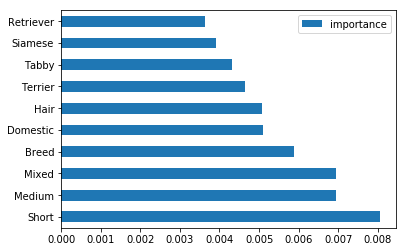

In [58]:
breed_keywords2.iloc[:10,:].plot.barh()

# Submitting test data

In [40]:
rfc = RandomForestClassifier(n_estimators=200, random_state=rnd)
rfc.fit(X_train_all, y_train_all)
prediction = rfc.predict(X_test_all)

In [41]:
submission = pd.DataFrame({'AdoptionSpeed': prediction.astype(int)}, index=X_test_all.index)
submission.to_csv("submission.csv", index=True, index_label='PetID', header=['AdoptionSpeed'])